# A Sentiment Analysis of MLB Performance
### ADS-509 Final Project Team 11

In [19]:
#Install reqired libraries
!pip install beautifulsoup4 requests
!pip install tqdm

In [20]:
#Import required libraries
import requests
from bs4 import BeautifulSoup
import pandas as pd
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from string import punctuation
from wordcloud import WordCloud 
import re
from collections import Counter
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

The first step in our effort is to scrape blog post text from the mlbtraderumors.com website.  This posts include text, dates posted, and the authors name.  We will scrape this information and store it in a dataframe that we can use to start our text analysis.

# Get text data

In [21]:
def scrape_website(url, file_path):
    # Send a GET request to the website
    response = requests.get(url)

    # Parse the HTML content using BeautifulSoup
    soup = BeautifulSoup(response.content, "html.parser")

    # Find all the news article elements
    articles = soup.find_all("article")

    # Create lists to store the extracted values
    titles = []
    authors = []
    dates = []
    contents = []

    # Iterate over the articles and extract the text
    with open(file_path, "w", encoding="utf-8") as file:
        for article in articles:
            # Extract the article title
            title_element = article.find("h2")
            title = title_element.text.strip() if title_element else ""
            titles.append(title)

            # Extract the article author
            author_element = article.find("span", class_="entry-author")
            author = author_element.text.strip() if author_element else ""
            authors.append(author)

            # Extract the article date
            date_element = article.find("time", class_="entry-time")
            date = date_element.text.strip() if date_element else ""
            dates.append(date)

            # Extract the article content
            content_element = article.find("div", class_="entry-content")
            content = content_element.text.strip() if content_element else ""
            contents.append(content)

            # Write the title and content to the file
            file.write("Title: " + title + "\n")
            file.write("Author: " + author + "\n")
            file.write("Date: " + date + "\n")
            file.write("Content: " + content + "\n")
            file.write("---\n")

    # Create a DataFrame from the extracted values
    data = {
        "Title": titles,
        "Author": authors,
        "Date": dates,
        "Content": contents
    }

    df = pd.DataFrame(data)

    # Drop rows without content
    df.dropna()

    return df

# Washington Nationals Data Collection and Cleaning

In [41]:
# URL of the website to scrape
url = "https://www.mlbtraderumors.com/washington-nationals?show=all"
file_path = "C:/Users/earne/OneDrive - University of San Diego/MSADS/ADS-509/Project/data/mlbtraderumors_washington_nationals_articles1.txt"

# Scrape the website, write the scraped text to a file, and get the head of the DataFrame
df = scrape_website(url, file_path)
df.head()

,Title,Author,Date,Content
0,"Sean Doolittle Completes Rehab Assignment, Hea...",Steve Adams,"June 15, 2023",Veteran lefty Sean Doolittle was transferred f...
1,Nationals Release Erasmo Ramírez,Darragh McDonald,"June 9, 2023",The Nationals have released right-hander Erasm...
2,Best Deadline Rental Returns In Recent History...,Darragh McDonald,"June 8, 2023",With the trade deadline now less than two mont...
3,Nationals Claim Joe La Sorsa,Steve Adams,"June 8, 2023",The Nationals have claimed left-hander Joe La ...
4,Nationals Outright Andres Machado,Anthony Franco,"June 7, 2023",Nationals reliever Andrés Machado has gone unc...


In [42]:
#change the Date column to a datetime object:
df['Date'] = pd.to_datetime(df['Date'], format="%B %d, %Y", errors= 'coerce')

In [43]:
df.dtypes

Title              object
Author             object
Date       datetime64[ns]
Content            object
dtype: object

In [80]:
# Check for missing values
df.isna().sum()

Title      0
Author     0
Date       0
Content    0
dtype: int64

In [45]:
len(df)

1030

In [46]:
df = df.dropna()
df

,Title,Author,Date,Content
0,"Sean Doolittle Completes Rehab Assignment, Hea...",Steve Adams,2023-06-15,Veteran lefty Sean Doolittle was transferred f...
1,Nationals Release Erasmo Ramírez,Darragh McDonald,2023-06-09,The Nationals have released right-hander Erasm...
2,Best Deadline Rental Returns In Recent History...,Darragh McDonald,2023-06-08,With the trade deadline now less than two mont...
3,Nationals Claim Joe La Sorsa,Steve Adams,2023-06-08,The Nationals have claimed left-hander Joe La ...
4,Nationals Outright Andres Machado,Anthony Franco,2023-06-07,Nationals reliever Andrés Machado has gone unc...
...,...,...,...,...
995,"Nationals Notes: Deadline, Scherzer, Zimmerman",Steve Adams,2019-06-28,The resurgent Nationals have won eight of thei...
996,Alex Meyer Retires,Connor Byrne,2019-06-25,Right-hander Alex Meyer has announced his reti...
997,Nationals Select Jonny Venters,Steve Adams,2019-06-25,"3:25pm: To make room for Venters and Rodney, t..."
998,Nationals To Select Fernando Rodney On Tuesday,Connor Byrne,2019-06-24,The Nationals will add right-handed reliever F...


In [60]:
len(df)

1000

## Import data on the washington nationals from baseball-reference.com

https://www.baseball-reference.com/teams/WSN/attend.shtml

In [47]:
import pandas as pd

# URL of the webpage to scrape
url = "https://www.baseball-reference.com/teams/WSN/attend.shtml"

# Read the HTML table into a list of DataFrames
tables = pd.read_html(url)

# Select the table of interest (index 0 in this case)
table = tables[0]

# Save the DataFrame as a CSV file
file_path = "C:/Users/earne/OneDrive - University of San Diego/MSADS/ADS-509/Project/data/attendance_data.csv"
table.to_csv(file_path, index=False, header=True)

print("Data saved to", file_path)




Data saved to C:/Users/earne/OneDrive - University of San Diego/MSADS/ADS-509/Project/data/attendance_data.csv


In [48]:
path = "C:/Users/earne/OneDrive - University of San Diego/MSADS/ADS-509/Project/data/"

nats_df = pd.DataFrame(pd.read_csv(path + 'attendance_data.csv'))
nats_df.head()

,Year,Tm,Lg,W,L,Finish,Playoffs,Attendance,Attend/G,Rank,Est. Payroll,PPF,BPF,Stadium
0,2023,Washington Nationals,NL East,27,44,5,NaN,810220.0,21898.0,12th of 15,"$98,376,067",96,94,Nationals Park
1,2022,Washington Nationals,NL East,55,107,5,NaN,2026401.0,25017.0,11th of 15,"$125,051,666",96,94,Nationals Park
2,2021,Washington Nationals,NL East,65,97,5,NaN,1465543.0,18093.0,12th of 15,"$172,370,147",96,95,Nationals Park
3,2020,Washington Nationals,NL East,26,34,5,NaN,NaN,NaN,15th of 15,"$172,237,283",99,99,Nationals Park
4,2019,Washington Nationals,NL East,93,69,2,Won WS (4-3),2259781.0,27899.0,11th of 15,"$203,016,595",102,102,Nationals Park


In [49]:
nats_df= nats_df[nats_df['Year'] > 2004]
nats_df

,Year,Tm,Lg,W,L,Finish,Playoffs,Attendance,Attend/G,Rank,Est. Payroll,PPF,BPF,Stadium
0,2023,Washington Nationals,NL East,27,44,5,NaN,810220.0,21898.0,12th of 15,"$98,376,067",96,94,Nationals Park
1,2022,Washington Nationals,NL East,55,107,5,NaN,2026401.0,25017.0,11th of 15,"$125,051,666",96,94,Nationals Park
2,2021,Washington Nationals,NL East,65,97,5,NaN,1465543.0,18093.0,12th of 15,"$172,370,147",96,95,Nationals Park
3,2020,Washington Nationals,NL East,26,34,5,NaN,NaN,NaN,15th of 15,"$172,237,283",99,99,Nationals Park
4,2019,Washington Nationals,NL East,93,69,2,Won WS (4-3),2259781.0,27899.0,11th of 15,"$203,016,595",102,102,Nationals Park
5,2018,Washington Nationals,NL East,82,80,2,NaN,2529604.0,31230.0,8th of 15,"$188,886,699",105,106,Nationals Park
6,2017,Washington Nationals,NL East,97,65,1,Lost NLDS (3-2),2524980.0,31173.0,7th of 15,"$175,587,301",103,104,Nationals Park
7,2016,Washington Nationals,NL East,95,67,1,Lost NLDS (3-2),2481938.0,30641.0,7th of 15,"$152,967,400",102,103,Nationals Park
8,2015,Washington Nationals,NL East,83,79,2,NaN,2619843.0,32344.0,5th of 15,"$176,496,372",101,102,Nationals Park
9,2014,Washington Nationals,NL East,96,66,1,Lost NLDS (3-1),2579389.0,31844.0,7th of 15,"$137,235,080",102,104,Nationals Park


In [50]:
#remove the dollar sign from Est. Payroll column
nats_df['Est. Payroll'] = nats_df['Est. Payroll'].replace({'\$':''}, regex = True)
nats_df['Est. Payroll'] = nats_df['Est. Payroll'].replace({'\,':''}, regex = True)
nats_df.head()

,Year,Tm,Lg,W,L,Finish,Playoffs,Attendance,Attend/G,Rank,Est. Payroll,PPF,BPF,Stadium
0,2023,Washington Nationals,NL East,27,44,5,NaN,810220.0,21898.0,12th of 15,98376067,96,94,Nationals Park
1,2022,Washington Nationals,NL East,55,107,5,NaN,2026401.0,25017.0,11th of 15,125051666,96,94,Nationals Park
2,2021,Washington Nationals,NL East,65,97,5,NaN,1465543.0,18093.0,12th of 15,172370147,96,95,Nationals Park
3,2020,Washington Nationals,NL East,26,34,5,NaN,NaN,NaN,15th of 15,172237283,99,99,Nationals Park
4,2019,Washington Nationals,NL East,93,69,2,Won WS (4-3),2259781.0,27899.0,11th of 15,203016595,102,102,Nationals Park


In [51]:
nats_df['Est. Payroll'] = nats_df['Est. Payroll'].astype(float)
nats_df.dtypes

Year              int64
Tm               object
Lg               object
W                 int64
L                 int64
Finish            int64
Playoffs         object
Attendance      float64
Attend/G        float64
Rank             object
Est. Payroll    float64
PPF               int64
BPF               int64
Stadium          object
dtype: object

### Create Binary feature that defines a successful year as wins greater than or equal to 50% of total games played

In [54]:
#Add a column to define a binary output that has a 1 if the team has a winning record for the year, and 0 if they do not
nats_df['success'] = (nats_df['W'] / (nats_df['W'] + nats_df['L']) >= 0.5).astype(int)
nats_df.head()

,Year,Tm,Lg,W,L,Finish,Playoffs,Attendance,Attend/G,Rank,Est. Payroll,PPF,BPF,Stadium,success
0,2023,Washington Nationals,NL East,27,44,5,NaN,810220.0,21898.0,12th of 15,98376067.0,96,94,Nationals Park,0
1,2022,Washington Nationals,NL East,55,107,5,NaN,2026401.0,25017.0,11th of 15,125051666.0,96,94,Nationals Park,0
2,2021,Washington Nationals,NL East,65,97,5,NaN,1465543.0,18093.0,12th of 15,172370147.0,96,95,Nationals Park,0
3,2020,Washington Nationals,NL East,26,34,5,NaN,NaN,NaN,15th of 15,172237283.0,99,99,Nationals Park,0
4,2019,Washington Nationals,NL East,93,69,2,Won WS (4-3),2259781.0,27899.0,11th of 15,203016595.0,102,102,Nationals Park,1


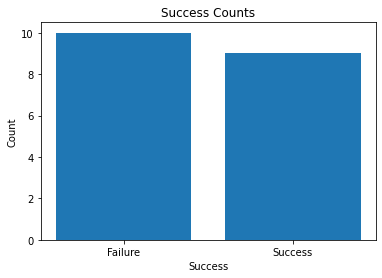

In [55]:
# Count the number of successes and failures
success_counts = nats_df['success'].value_counts()

# Create a bar plot
plt.bar(success_counts.index, success_counts.values)
plt.xticks(success_counts.index, ['Failure', 'Success'])
plt.xlabel('Success')
plt.ylabel('Count')
plt.title('Success Counts')

# Display the plot
plt.show()

In [56]:
nats_df.describe()

,Year,W,L,Finish,Attendance,Attend/G,Est. Payroll,PPF,BPF,success
count,19.000000,19.000000,19.000000,19.000000,1.800000e+01,18.000000,1.900000e+01,19.000000,19.000000,19.000000
mean,2014.000000,73.421053,78.315789,3.368421,2.169775e+06,27484.777778,1.163850e+08,99.526316,99.263158,0.473684
std,5.627314,21.341966,19.359329,1.738790,4.883064e+05,4544.568362,5.466072e+07,2.988281,3.983886,0.512989
min,2005.000000,26.000000,34.000000,1.000000,8.102200e+05,18093.000000,3.694750e+07,95.000000,94.000000,0.000000
25%,2009.500000,62.000000,66.500000,2.000000,1.941312e+06,24062.500000,6.604250e+07,96.000000,95.000000,0.000000
50%,2014.000000,80.000000,80.000000,4.000000,2.290090e+06,28452.000000,1.124932e+08,100.000000,99.000000,0.000000
75%,2018.500000,89.500000,92.000000,5.000000,2.528448e+06,31215.750000,1.723037e+08,101.500000,102.500000,1.000000
max,2023.000000,98.000000,107.000000,5.000000,2.731993e+06,33728.000000,2.030166e+08,105.000000,106.000000,1.000000


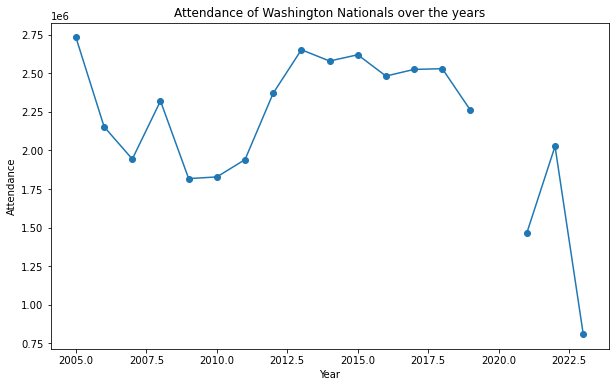

In [57]:
#plot data
# Plotting
# Convert columns to numpy arrays
year = np.array(nats_df['Year'])
attendance = np.array(nats_df['Attendance'])

plt.figure(figsize= (10,6))

# Plotting Attendance over the years
plt.plot(year, attendance, marker='o')
plt.xlabel('Year')
plt.ylabel('Attendance')
plt.title('Attendance of Washington Nationals over the years')

# Display the plot
plt.show()

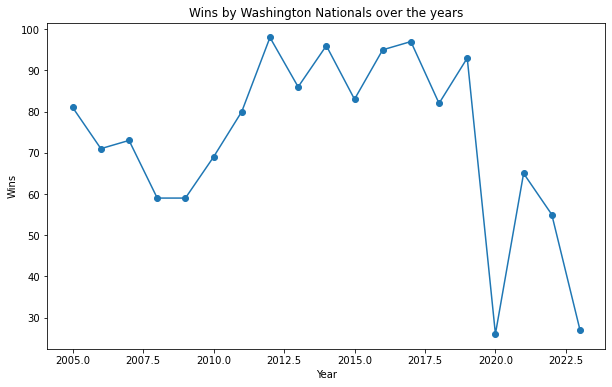

In [32]:
# Plotting Wins over the years
# Convert columns to numpy arrays
year = np.array(nats_df['Year'])
wins = np.array(nats_df['W'])

plt.figure(figsize= (10,6))

# Plotting Attendance over the years
plt.plot(year, wins, marker='o')
plt.xlabel('Year')
plt.ylabel('Wins')
plt.title('Wins by Washington Nationals over the years')

# Display the plot
plt.show()

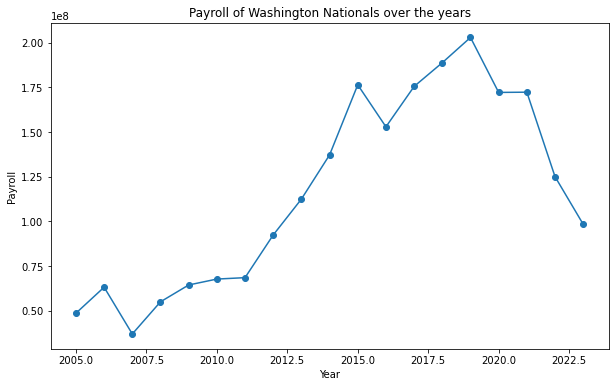

In [33]:
# Plotting Payroll over the years
# Convert columns to numpy arrays
year = np.array(nats_df['Year'])
payroll = np.array(nats_df['Est. Payroll'])

plt.figure(figsize= (10,6))

# Plotting Attendance over the years
plt.plot(year, payroll, marker='o')
plt.xlabel('Year')
plt.ylabel('Payroll')
plt.title('Payroll of Washington Nationals over the years')

# Display the plot
plt.show()

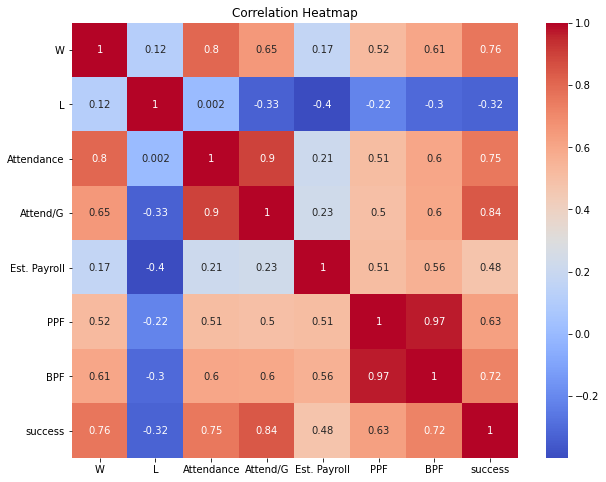

In [58]:
import seaborn as sns

# Select numeric columns for correlation analysis
numeric_cols = ['W', 'L', 'Attendance', 'Attend/G', 'Est. Payroll', 'PPF', 'BPF', 'success']
numeric_df = nats_df[numeric_cols]

# Correlation matrix
correlation = numeric_df.corr()

# Plotting the correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')

# Display the plot
plt.show()


Add column to for whether blog post occured in a successful year or not.

In [61]:
# Extract the year from the "Date" column in df DataFrame
df['Year'] = pd.to_datetime(df['Date']).dt.year

# Merge df and nats_df DataFrames on the "Year" column
merged_df = pd.merge(df, nats_df[['Year', 'success']], on='Year', how='left')

# Add a new column 'Year_Successful' based on 'success' column
merged_df['Year_Successful'] = merged_df['success'].fillna(0).astype(int)

merged_df.head()

,Title,Author,Date,Content,Year,success,Year_Successful
0,"Sean Doolittle Completes Rehab Assignment, Hea...",Steve Adams,2023-06-15,Veteran lefty Sean Doolittle was transferred f...,2023,0,0
1,Nationals Release Erasmo Ramírez,Darragh McDonald,2023-06-09,The Nationals have released right-hander Erasm...,2023,0,0
2,Best Deadline Rental Returns In Recent History...,Darragh McDonald,2023-06-08,With the trade deadline now less than two mont...,2023,0,0
3,Nationals Claim Joe La Sorsa,Steve Adams,2023-06-08,The Nationals have claimed left-hander Joe La ...,2023,0,0
4,Nationals Outright Andres Machado,Anthony Franco,2023-06-07,Nationals reliever Andrés Machado has gone unc...,2023,0,0


In [62]:
len(merged_df)

1000

## Cleaning the Data

In [63]:
#Identify any noise in the data
RE_SUSPICIOUS = re.compile(r'[&#<>{}\[\]\\]')

def impurity(text, min_len=10):
    """returns the share of suspicious characters in a text"""
    if text == None or len(text) < min_len:
        return 0
    else:
        return len(RE_SUSPICIOUS.findall(text))/len(text)


In [64]:
merged_df['Content'].apply

<bound method Series.apply of 0      Veteran lefty Sean Doolittle was transferred f...
1      The Nationals have released right-hander Erasm...
2      With the trade deadline now less than two mont...
3      The Nationals have claimed left-hander Joe La ...
4      Nationals reliever Andrés Machado has gone unc...
                             ...                        
995    The resurgent Nationals have won eight of thei...
996    Right-hander Alex Meyer has announced his reti...
997    3:25pm: To make room for Venters and Rodney, t...
998    The Nationals will add right-handed reliever F...
999    The Nationals have released reliever Trevor Ro...
Name: Content, Length: 1000, dtype: object>

In [65]:
pd.options.display.max_colwidth = 100 ###
# add new column to data frame
merged_df['impurity'] = merged_df['Content'].apply(impurity, min_len=10)

# get the top 3 records
merged_df[['Content', 'impurity']].sort_values(by='impurity', ascending=False).head(3)

,Content,impurity
601,The Nationals announced they’ve selected the contract of right-hander Steven Fuentes. The 23-yea...,0.003333
559,"Kyle Schwarber is now a member of the Washington Nationals, in no small part because of Nats man...",0.003155
565,The Nationals accomplished a big part of their winter to-do list when they acquired Josh Bell fr...,0.002786


The above shows the highest impurity levels for this data set.  Note, these are extremely low...well below 1% of all characters in each blog post are suspicious.

Now we'll do some character normalization and tokenization

In [66]:
import re
import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

# Example function to normalize the text in the "Contents" column
def normalize_text(text):
    # Lowercase the text
    text = text.lower()

    # Remove punctuation
    text = text.translate(str.maketrans("", "", string.punctuation))

    # Remove special characters and digits
    text = re.sub(r"[^a-zA-Z]", " ", text)

    # Tokenize the text
    tokens = word_tokenize(text)

    # Remove stopwords
    stop_words = set(stopwords.words("english"))
    tokens = [token for token in tokens if token not in stop_words]

    # Perform stemming
    stemmer = PorterStemmer()
    tokens = [stemmer.stem(token) for token in tokens]

    return tokens

# Apply normalization to the "Contents" column
merged_df["Contents_Normalized"] = merged_df["Content"].apply(normalize_text)

# Print the head of the DataFrame with the normalized contents
merged_df[["Content", "Contents_Normalized"]].head()


,Content,Contents_Normalized
0,Veteran lefty Sean Doolittle was transferred from the Nationals’ Double-A affiliate to their Tri...,"[veteran, lefti, sean, doolittl, transfer, nation, doublea, affili, triplea, club, thursday, sig..."
1,"The Nationals have released right-hander Erasmo Ramírez, according to his transactions tracker a...","[nation, releas, righthand, erasmo, ram, rez, accord, transact, tracker, mlbcom, design, assign,..."
2,"With the trade deadline now less than two months away, we at MLBTR are setting our sights backwa...","[trade, deadlin, less, two, month, away, mlbtr, set, sight, backward, bit, highlight, past, trad..."
3,"The Nationals have claimed left-hander Joe La Sorsa off waivers from the Rays, the team announce...","[nation, claim, lefthand, joe, la, sorsa, waiver, ray, team, announc, thursday, la, sorsa, desig..."
4,Nationals reliever Andrés Machado has gone unclaimed on waivers after being designated for assig...,"[nation, reliev, andr, machado, gone, unclaim, waiver, design, assign, week, club, announc, mach..."


In [67]:
merged_df['length'] = merged_df['Contents_Normalized'].str.len()
merged_df.head()

,Title,Author,Date,Content,Year,success,Year_Successful,impurity,Contents_Normalized,length
0,"Sean Doolittle Completes Rehab Assignment, Heads To Triple-A Rochester",Steve Adams,2023-06-15,Veteran lefty Sean Doolittle was transferred from the Nationals’ Double-A affiliate to their Tri...,2023,0,0,0.000000,"[veteran, lefti, sean, doolittl, transfer, nation, doublea, affili, triplea, club, thursday, sig...",60
1,Nationals Release Erasmo Ramírez,Darragh McDonald,2023-06-09,"The Nationals have released right-hander Erasmo Ramírez, according to his transactions tracker a...",2023,0,0,0.000000,"[nation, releas, righthand, erasmo, ram, rez, accord, transact, tracker, mlbcom, design, assign,...",130
2,"Best Deadline Rental Returns In Recent History, #8: Nationals Get Everyday Outfielder For Jon Le...",Darragh McDonald,2023-06-08,"With the trade deadline now less than two months away, we at MLBTR are setting our sights backwa...",2023,0,0,0.000441,"[trade, deadlin, less, two, month, away, mlbtr, set, sight, backward, bit, highlight, past, trad...",607
3,Nationals Claim Joe La Sorsa,Steve Adams,2023-06-08,"The Nationals have claimed left-hander Joe La Sorsa off waivers from the Rays, the team announce...",2023,0,0,0.000000,"[nation, claim, lefthand, joe, la, sorsa, waiver, ray, team, announc, thursday, la, sorsa, desig...",158
4,Nationals Outright Andres Machado,Anthony Franco,2023-06-07,Nationals reliever Andrés Machado has gone unclaimed on waivers after being designated for assig...,2023,0,0,0.000000,"[nation, reliev, andr, machado, gone, unclaim, waiver, design, assign, week, club, announc, mach...",136


## Look at descriptive stats for text in dataframe

<AxesSubplot:>

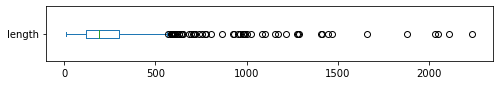

In [68]:
merged_df['length'].plot(kind='box', vert=False, figsize=(8, 1))

<AxesSubplot:>

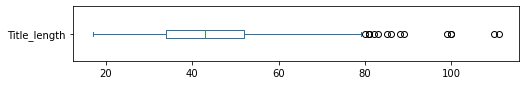

In [70]:
merged_df['Title_length'] = merged_df['Title'].str.len()
merged_df['Title_length'].plot(kind='box', vert=False, figsize=(8, 1))

<AxesSubplot:ylabel='Frequency'>

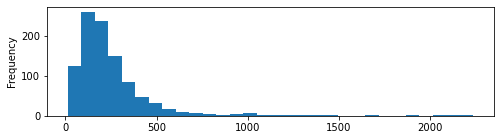

In [71]:
merged_df['length'].plot(kind='hist', bins=30, figsize=(8,2))

<AxesSubplot:title={'center':'Avg. Post Length'}, xlabel='Month'>

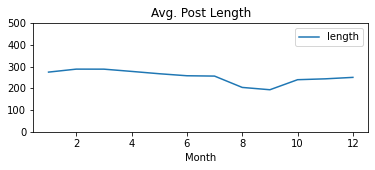

In [72]:
# Extract the month from the date and create a new column
merged_df['Month'] = merged_df['Date'].dt.month

# Plot the average post length
merged_df.groupby('Month').agg({'length': 'mean'}) \
  .plot(title="Avg. Post Length", ylim=(0,500), figsize=(6,2))


In [73]:
def count_words(df, column='Contents_Normalized', preprocess=None, min_freq=2):

    # process tokens and update counter
    def update(doc):
        tokens = doc if preprocess is None else preprocess(doc)
        counter.update(tokens)

    # create counter and run through all data
    counter = Counter()
    tqdm.pandas() #initialize tqdm for progress bar
    df[column].apply(update)

    # transform counter into data frame
    freq_df = pd.DataFrame.from_dict(counter, orient='index', columns=['freq'])
    freq_df = freq_df.query('freq >= @min_freq')
    freq_df.index.name = 'token'
    
    return freq_df.sort_values('freq', ascending=False)

In [74]:
freq_df = count_words(merged_df)
freq_df.head(5)

,freq
token,
season,3102
nation,2758
year,2411
leagu,1804
nat,1609


In [75]:
#How many tokens are in the df?
len(freq_df)

6440

In [77]:
# top words with 10+ characters
count_words(merged_df, column='Content', 
            preprocess=lambda Content: re.findall(r"\w{10,}", Content)).head(5)



,freq
token,
Washington,1259
appearances,618
organization,384
outfielder,258
arbitration,254


[Text(0.5, 0, 'Frequency'), Text(0, 0.5, 'Token'), Text(0.5, 1.0, 'Top Words')]

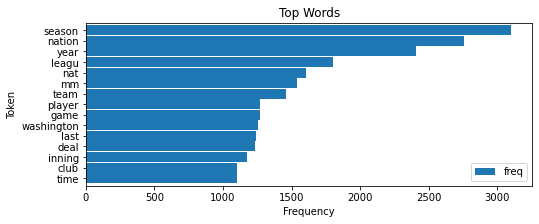

In [78]:
ax = freq_df.head(15).plot(kind='barh', width=0.95, figsize=(8,3))
ax.invert_yaxis()
ax.set(xlabel='Frequency', ylabel='Token', title='Top Words')

# San Diego Padres Data Collection and Cleaning

In [106]:
# URL of the website to scrape
url = "https://www.mlbtraderumors.com/san-diego-padres?show=all"
file_path = "C:/Users/earne/OneDrive - University of San Diego/MSADS/ADS-509/Project/data/mlbtraderumors_padres_articles1.txt"

# Scrape the website, write the scraped text to a file, and get the head of the DataFrame
sd_df = scrape_website(url, file_path)
sd_df.head()

,Title,Author,Date,Content
0,Jose Iglesias Opts Out Of Contract With Padres,Anthony Franco,"June 19, 2023","Veteran infielder José Iglesias has opted out of his minor league deal with the Padres, reports ..."
1,Seth Lugo To Return Tuesday,Nick Deeds,"June 18, 2023","The Padres expect to welcome right-hander Seth Lugo back into the fold on Tuesday, when he figur..."
2,Padres Select Preston Tucker,Nick Deeds,"June 18, 2023","In a somewhat unusual move, the Padres have selected the contract of outfielder Preston Tucker b..."
3,Juan Soto Has Found His Stride After Slow Start,Anthony Franco,"June 13, 2023","Early in the year, there was a decent amount of trepidation about Juan Soto. The Padres supersta..."
4,Jack Baldschun Passes Away,Anthony Franco,"June 9, 2023","Former big league reliever Jack Baldschun passed away this week after a battle with leukemia, ac..."


In [107]:
#change the Date column to a datetime object:
sd_df['Date'] = pd.to_datetime(sd_df['Date'], format="%B %d, %Y", errors= 'coerce')

In [108]:
sd_df.dtypes

Title              object
Author             object
Date       datetime64[ns]
Content            object
dtype: object

In [109]:
# Check for missing values
sd_df.isna().sum()

Title       0
Author      0
Date       30
Content     0
dtype: int64

In [110]:
len(sd_df)

1030

In [111]:
sd_df = sd_df.dropna()
sd_df

,Title,Author,Date,Content
0,Jose Iglesias Opts Out Of Contract With Padres,Anthony Franco,2023-06-19,"Veteran infielder José Iglesias has opted out of his minor league deal with the Padres, reports ..."
1,Seth Lugo To Return Tuesday,Nick Deeds,2023-06-18,"The Padres expect to welcome right-hander Seth Lugo back into the fold on Tuesday, when he figur..."
2,Padres Select Preston Tucker,Nick Deeds,2023-06-18,"In a somewhat unusual move, the Padres have selected the contract of outfielder Preston Tucker b..."
3,Juan Soto Has Found His Stride After Slow Start,Anthony Franco,2023-06-13,"Early in the year, there was a decent amount of trepidation about Juan Soto. The Padres supersta..."
4,Jack Baldschun Passes Away,Anthony Franco,2023-06-09,"Former big league reliever Jack Baldschun passed away this week after a battle with leukemia, ac..."
...,...,...,...,...
995,"Latest On Cordero, Richards, Nix",Mark Polishuk,2019-09-07,"Franchy Cordero has suffered another setback while rehabbing a quad injury, Jeff Sanders of the ..."
996,Adrian Morejon Will Not Return To Majors This Year,Jeff Todd,2019-09-04,"Padres southpaw Adrian Morejon will not make it back to the bigs in 2019, Dennis Lin of The Athl..."
997,Padres Select Seth Mejias-Brean,Steve Adams,2019-09-03,The Padres announced prior to tonight’s game that they’ve selected the contract of infielder Set...
998,Padres Select Ronald Bolanos,Steve Adams,2019-09-02,The Padres announced Monday that they’ve selected the contract of right-hander Ronald Bolanos fr...


In [112]:
len(sd_df)

1000

## Import data on the San Diego Padres from baseball-reference.com

https://www.baseball-reference.com/teams/SDP/attend.shtml

In [90]:
import pandas as pd

# URL of the webpage to scrape
url = "https://www.baseball-reference.com/teams/SDP/attend.shtml"

# Read the HTML table into a list of DataFrames
tables = pd.read_html(url)

# Select the table of interest (index 0 in this case)
table = tables[0]

# Save the DataFrame as a CSV file
file_path = "C:/Users/earne/OneDrive - University of San Diego/MSADS/ADS-509/Project/data/sdp_attendance_data.csv"
table.to_csv(file_path, index=False, header=True)

print("Data saved to", file_path)




Data saved to C:/Users/earne/OneDrive - University of San Diego/MSADS/ADS-509/Project/data/sdp_attendance_data.csv


In [91]:
path = "C:/Users/earne/OneDrive - University of San Diego/MSADS/ADS-509/Project/data/"

pads_df = pd.DataFrame(pd.read_csv(path + 'sdp_attendance_data.csv'))
pads_df.head()

,Year,Tm,Lg,W,L,Finish,Playoffs,Attendance,Attend/G,Rank,Est. Payroll,PPF,BPF,Stadium
0,2023,San Diego Padres,NL West,35,37,4,NaN,1549480.0,39730.0,2nd of 15,"$234,100,139",93,93,Petco Park
1,2022,San Diego Padres,NL West,89,73,2,Lost NLCS (4-1),2987470.0,36882.0,4th of 15,"$173,600,824",93,93,Petco Park
2,2021,San Diego Padres,NL West,79,83,3,NaN,2191950.0,27061.0,3rd of 15,"$151,984,286",92,92,Petco Park
3,2020,San Diego Padres,NL West,37,23,2,Lost NLDS (3-0),NaN,NaN,12th of 15,"$141,953,667",93,93,Petco Park
4,2019,San Diego Padres,NL West,70,92,5,NaN,2396399.0,29585.0,10th of 15,"$90,260,767",95,94,Petco Park


In [92]:
pads_df= pads_df[nats_df['Year'] > 2004]
pads_df

,Year,Tm,Lg,W,L,Finish,Playoffs,Attendance,Attend/G,Rank,Est. Payroll,PPF,BPF,Stadium
0,2023,San Diego Padres,NL West,35,37,4,NaN,1549480.0,39730.0,2nd of 15,"$234,100,139",93,93,Petco Park
1,2022,San Diego Padres,NL West,89,73,2,Lost NLCS (4-1),2987470.0,36882.0,4th of 15,"$173,600,824",93,93,Petco Park
2,2021,San Diego Padres,NL West,79,83,3,NaN,2191950.0,27061.0,3rd of 15,"$151,984,286",92,92,Petco Park
3,2020,San Diego Padres,NL West,37,23,2,Lost NLDS (3-0),NaN,NaN,12th of 15,"$141,953,667",93,93,Petco Park
4,2019,San Diego Padres,NL West,70,92,5,NaN,2396399.0,29585.0,10th of 15,"$90,260,767",95,94,Petco Park
5,2018,San Diego Padres,NL West,66,96,5,NaN,2168536.0,26772.0,11th of 15,"$93,821,067",95,93,Petco Park
6,2017,San Diego Padres,NL West,71,91,4,NaN,2138491.0,26401.0,10th of 15,"$49,248,767",97,95,Petco Park
7,2016,San Diego Padres,NL West,68,94,5,NaN,2351422.0,29030.0,8th of 15,"$50,656,166",95,95,Petco Park
8,2015,San Diego Padres,NL West,74,88,4,NaN,2459752.0,30367.0,10th of 15,"$125,203,700",95,95,Petco Park
9,2014,San Diego Padres,NL West,77,85,3,NaN,2195373.0,27103.0,12th of 15,"$76,662,100",92,92,Petco Park


In [93]:
#remove the dollar sign from Est. Payroll column
pads_df['Est. Payroll'] = pads_df['Est. Payroll'].replace({'\$':''}, regex = True)
pads_df['Est. Payroll'] = pads_df['Est. Payroll'].replace({'\,':''}, regex = True)
pads_df.head()

,Year,Tm,Lg,W,L,Finish,Playoffs,Attendance,Attend/G,Rank,Est. Payroll,PPF,BPF,Stadium
0,2023,San Diego Padres,NL West,35,37,4,NaN,1549480.0,39730.0,2nd of 15,234100139,93,93,Petco Park
1,2022,San Diego Padres,NL West,89,73,2,Lost NLCS (4-1),2987470.0,36882.0,4th of 15,173600824,93,93,Petco Park
2,2021,San Diego Padres,NL West,79,83,3,NaN,2191950.0,27061.0,3rd of 15,151984286,92,92,Petco Park
3,2020,San Diego Padres,NL West,37,23,2,Lost NLDS (3-0),NaN,NaN,12th of 15,141953667,93,93,Petco Park
4,2019,San Diego Padres,NL West,70,92,5,NaN,2396399.0,29585.0,10th of 15,90260767,95,94,Petco Park


In [94]:
pads_df['Est. Payroll'] = pads_df['Est. Payroll'].astype(float)
pads_df.dtypes

Year              int64
Tm               object
Lg               object
W                 int64
L                 int64
Finish            int64
Playoffs         object
Attendance      float64
Attend/G        float64
Rank             object
Est. Payroll    float64
PPF               int64
BPF               int64
Stadium          object
dtype: object

### Create Binary feature that defines a successful year as wins greater than or equal to 50% of total games played

In [97]:
#Add a column to define a binary output that has a 1 if the team has a winning record for the year, and 0 if they do not
pads_df['success'] = (pads_df['W'] / (pads_df['W'] + nats_df['L']) >= 0.5).astype(int)
pads_df.head()

,Year,Tm,Lg,W,L,Finish,Playoffs,Attendance,Attend/G,Rank,Est. Payroll,PPF,BPF,Stadium,success
0,2023,San Diego Padres,NL West,35,37,4,NaN,1549480.0,39730.0,2nd of 15,234100139.0,93,93,Petco Park,0
1,2022,San Diego Padres,NL West,89,73,2,Lost NLCS (4-1),2987470.0,36882.0,4th of 15,173600824.0,93,93,Petco Park,1
2,2021,San Diego Padres,NL West,79,83,3,NaN,2191950.0,27061.0,3rd of 15,151984286.0,92,92,Petco Park,0
3,2020,San Diego Padres,NL West,37,23,2,Lost NLDS (3-0),NaN,NaN,12th of 15,141953667.0,93,93,Petco Park,1
4,2019,San Diego Padres,NL West,70,92,5,NaN,2396399.0,29585.0,10th of 15,90260767.0,95,94,Petco Park,0


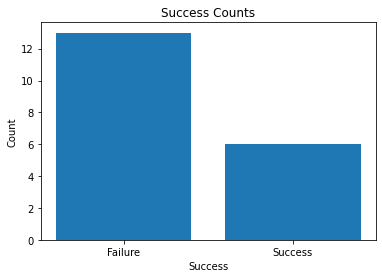

In [98]:
# Count the number of successes and failures
success_counts = pads_df['success'].value_counts()

# Create a bar plot
plt.bar(success_counts.index, success_counts.values)
plt.xticks(success_counts.index, ['Failure', 'Success'])
plt.xlabel('Success')
plt.ylabel('Count')
plt.title('Success Counts')

# Display the plot
plt.show()

In [99]:
pads_df.describe()

,Year,W,L,Finish,Attendance,Attend/G,Est. Payroll,PPF,BPF,success
count,19.000000,19.000000,19.000000,19.000000,1.800000e+01,18.000000,1.900000e+01,19.000000,19.000000,19.000000
mean,2014.000000,72.421053,79.526316,3.421053,2.315046e+06,29725.222222,8.992487e+07,92.368421,92.105263,0.315789
std,5.627314,15.104509,19.288363,1.346427,3.508207e+05,4407.785713,5.233473e+07,2.290331,2.024701,0.477567
min,2005.000000,35.000000,23.000000,1.000000,1.549480e+06,23699.000000,3.779930e+07,88.000000,87.000000,0.000000
25%,2009.500000,69.000000,74.000000,2.500000,2.139623e+06,26530.000000,5.322445e+07,91.000000,91.000000,0.000000
50%,2014.000000,75.000000,86.000000,4.000000,2.193662e+06,28066.500000,6.989614e+07,92.000000,92.000000,0.000000
75%,2018.500000,80.500000,91.000000,4.500000,2.451698e+06,32219.500000,1.095124e+08,94.000000,93.000000,1.000000
max,2023.000000,90.000000,99.000000,5.000000,2.987470e+06,39730.000000,2.341001e+08,97.000000,95.000000,1.000000


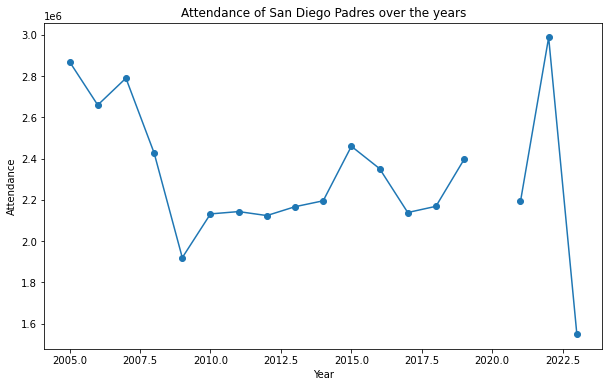

In [100]:
# Plotting
# Convert columns to numpy arrays
year = np.array(pads_df['Year'])
attendance = np.array(pads_df['Attendance'])

plt.figure(figsize= (10,6))

# Plotting Attendance over the years
plt.plot(year, attendance, marker='o')
plt.xlabel('Year')
plt.ylabel('Attendance')
plt.title('Attendance of San Diego Padres over the years')

# Display the plot
plt.show()

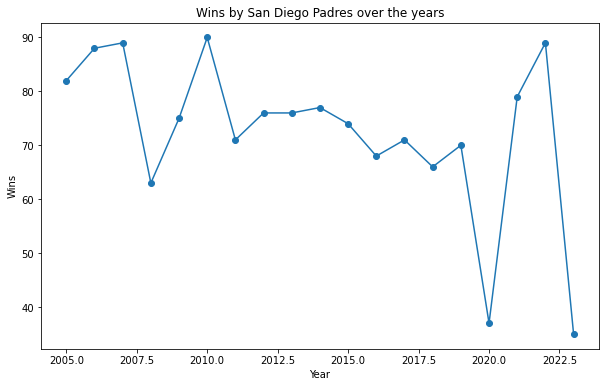

In [101]:
# Plotting Wins over the years
# Convert columns to numpy arrays
year = np.array(pads_df['Year'])
wins = np.array(pads_df['W'])

plt.figure(figsize= (10,6))

# Plotting Attendance over the years
plt.plot(year, wins, marker='o')
plt.xlabel('Year')
plt.ylabel('Wins')
plt.title('Wins by San Diego Padres over the years')

# Display the plot
plt.show()

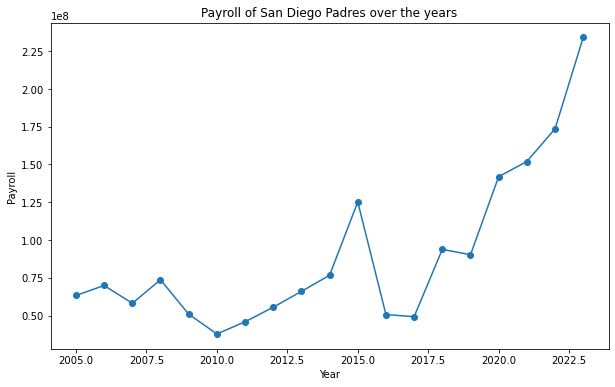

In [103]:
# Plotting Payroll over the years
# Convert columns to numpy arrays
year = np.array(pads_df['Year'])
payroll = np.array(pads_df['Est. Payroll'])

plt.figure(figsize= (10,6))

# Plotting Attendance over the years
plt.plot(year, payroll, marker='o')
plt.xlabel('Year')
plt.ylabel('Payroll')
plt.title('Payroll of San Diego Padres over the years')

# Display the plot
plt.show()

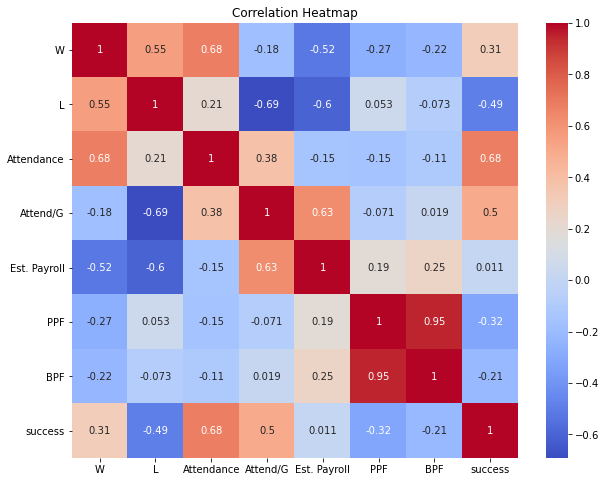

In [104]:
import seaborn as sns

# Select numeric columns for correlation analysis
numeric_cols = ['W', 'L', 'Attendance', 'Attend/G', 'Est. Payroll', 'PPF', 'BPF', 'success']
numeric_df = pads_df[numeric_cols]

# Correlation matrix
correlation = numeric_df.corr()

# Plotting the correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')

# Display the plot
plt.show()

In [113]:
# Extract the year from the "Date" column in df DataFrame
sd_df['Year'] = pd.to_datetime(sd_df['Date']).dt.year

# Merge df and pads_df DataFrames on the "Year" column
merged_sd_df = pd.merge(sd_df, pads_df[['Year', 'success']], on='Year', how='left')

# Add a new column 'Year_Successful' based on 'success' column
merged_sd_df['Year_Successful'] = merged_sd_df['success'].fillna(0).astype(int)

merged_sd_df.head()

,Title,Author,Date,Content,Year,success,Year_Successful
0,Jose Iglesias Opts Out Of Contract With Padres,Anthony Franco,2023-06-19,"Veteran infielder José Iglesias has opted out of his minor league deal with the Padres, reports ...",2023,0,0
1,Seth Lugo To Return Tuesday,Nick Deeds,2023-06-18,"The Padres expect to welcome right-hander Seth Lugo back into the fold on Tuesday, when he figur...",2023,0,0
2,Padres Select Preston Tucker,Nick Deeds,2023-06-18,"In a somewhat unusual move, the Padres have selected the contract of outfielder Preston Tucker b...",2023,0,0
3,Juan Soto Has Found His Stride After Slow Start,Anthony Franco,2023-06-13,"Early in the year, there was a decent amount of trepidation about Juan Soto. The Padres supersta...",2023,0,0
4,Jack Baldschun Passes Away,Anthony Franco,2023-06-09,"Former big league reliever Jack Baldschun passed away this week after a battle with leukemia, ac...",2023,0,0


In [114]:
len(merged_sd_df)

1000

##Cleaning the Data

In [ ]:
#Identify any noise in the data
RE_SUSPICIOUS = re.compile(r'[&#<>{}\[\]\\]')

def impurity(text, min_len=10):
    """returns the share of suspicious characters in a text"""
    if text == None or len(text) < min_len:
        return 0
    else:
        return len(RE_SUSPICIOUS.findall(text))/len(text)

In [115]:
merged_sd_df['Content'].apply

<bound method Series.apply of 0      Veteran infielder José Iglesias has opted out of his minor league deal with the Padres, reports ...
1      The Padres expect to welcome right-hander Seth Lugo back into the fold on Tuesday, when he figur...
2      In a somewhat unusual move, the Padres have selected the contract of outfielder Preston Tucker b...
3      Early in the year, there was a decent amount of trepidation about Juan Soto. The Padres supersta...
4      Former big league reliever Jack Baldschun passed away this week after a battle with leukemia, ac...
                                                      ...                                                 
995    Franchy Cordero has suffered another setback while rehabbing a quad injury, Jeff Sanders of the ...
996    Padres southpaw Adrian Morejon will not make it back to the bigs in 2019, Dennis Lin of The Athl...
997    The Padres announced prior to tonight’s game that they’ve selected the contract of infielder Set...
998    

In [116]:
pd.options.display.max_colwidth = 100 ###
# add new column to data frame
merged_sd_df['impurity'] = merged_sd_df['Content'].apply(impurity, min_len=10)

# get the top 3 records
merged_sd_df[['Content', 'impurity']].sort_values(by='impurity', ascending=False).head(3)

,Content,impurity
57,"Jake Cronenworth signed a seven-year, $80MM extension with the Padres, so what does that mean fo...",0.009479
127,"Major League Baseball’s international signing period for 2023 has officially opened up today, wi...",0.005563
838,What is the role of the Players’ Union in the Astros’ sign-stealing scandal? Why are the Padres ...,0.003484


The above shows the highest impurity levels for this data set.  Note, these are extremely low...well below 1% of all characters in each blog post are suspicious.

Now we'll do some character normalization and tokenization

In [ ]:
import re
import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

# Example function to normalize the text in the "Contents" column
def normalize_text(text):
    # Lowercase the text
    text = text.lower()

    # Remove punctuation
    text = text.translate(str.maketrans("", "", string.punctuation))

    # Remove special characters and digits
    text = re.sub(r"[^a-zA-Z]", " ", text)

    # Tokenize the text
    tokens = word_tokenize(text)

    # Remove stopwords
    stop_words = set(stopwords.words("english"))
    tokens = [token for token in tokens if token not in stop_words]

    # Perform stemming
    stemmer = PorterStemmer()
    tokens = [stemmer.stem(token) for token in tokens]

    return tokens

In [117]:
# Apply normalization to the "Contents" column
merged_sd_df["Contents_Normalized"] = merged_sd_df["Content"].apply(normalize_text)

# Print the head of the DataFrame with the normalized contents
merged_sd_df[["Content", "Contents_Normalized"]].head()

,Content,Contents_Normalized
0,"Veteran infielder José Iglesias has opted out of his minor league deal with the Padres, reports ...","[veteran, infield, jo, iglesia, opt, minor, leagu, deal, padr, report, mark, feinsand, mlbcom, t..."
1,"The Padres expect to welcome right-hander Seth Lugo back into the fold on Tuesday, when he figur...","[padr, expect, welcom, righthand, seth, lugo, back, fold, tuesday, figur, start, giant, san, fra..."
2,"In a somewhat unusual move, the Padres have selected the contract of outfielder Preston Tucker b...","[somewhat, unusu, move, padr, select, contract, outfield, preston, tucker, promptli, place, day,..."
3,"Early in the year, there was a decent amount of trepidation about Juan Soto. The Padres supersta...","[earli, year, decent, amount, trepid, juan, soto, padr, superstar, still, reach, base, excel, cl..."
4,"Former big league reliever Jack Baldschun passed away this week after a battle with leukemia, ac...","[former, big, leagu, reliev, jack, baldschun, pass, away, week, battl, leukemia, accord, obituar..."


In [118]:
merged_sd_df['length'] = merged_sd_df['Contents_Normalized'].str.len()
merged_sd_df.head()

,Title,Author,Date,Content,Year,success,Year_Successful,impurity,Contents_Normalized,length
0,Jose Iglesias Opts Out Of Contract With Padres,Anthony Franco,2023-06-19,"Veteran infielder José Iglesias has opted out of his minor league deal with the Padres, reports ...",2023,0,0,0.0,"[veteran, infield, jo, iglesia, opt, minor, leagu, deal, padr, report, mark, feinsand, mlbcom, t...",181
1,Seth Lugo To Return Tuesday,Nick Deeds,2023-06-18,"The Padres expect to welcome right-hander Seth Lugo back into the fold on Tuesday, when he figur...",2023,0,0,0.0,"[padr, expect, welcom, righthand, seth, lugo, back, fold, tuesday, figur, start, giant, san, fra...",76
2,Padres Select Preston Tucker,Nick Deeds,2023-06-18,"In a somewhat unusual move, the Padres have selected the contract of outfielder Preston Tucker b...",2023,0,0,0.0,"[somewhat, unusu, move, padr, select, contract, outfield, preston, tucker, promptli, place, day,...",306
3,Juan Soto Has Found His Stride After Slow Start,Anthony Franco,2023-06-13,"Early in the year, there was a decent amount of trepidation about Juan Soto. The Padres supersta...",2023,0,0,0.0,"[earli, year, decent, amount, trepid, juan, soto, padr, superstar, still, reach, base, excel, cl...",363
4,Jack Baldschun Passes Away,Anthony Franco,2023-06-09,"Former big league reliever Jack Baldschun passed away this week after a battle with leukemia, ac...",2023,0,0,0.0,"[former, big, leagu, reliev, jack, baldschun, pass, away, week, battl, leukemia, accord, obituar...",219


## Look at descriptive stats for text in dataframe

<AxesSubplot:>

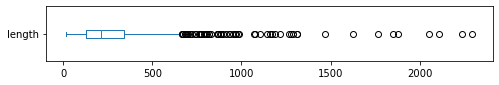

In [119]:
merged_sd_df['length'].plot(kind='box', vert=False, figsize=(8, 1))

<AxesSubplot:>

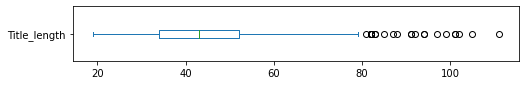

In [121]:
merged_sd_df['Title_length'] = merged_sd_df['Title'].str.len()
merged_sd_df['Title_length'].plot(kind='box', vert=False, figsize=(8, 1))

<AxesSubplot:ylabel='Frequency'>

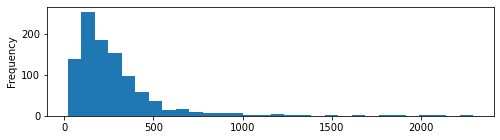

In [122]:
merged_sd_df['length'].plot(kind='hist', bins=30, figsize=(8,2))

In [123]:
# Extract the month from the date and create a new column
merged_sd_df['Month'] = merged_sd_df['Date'].dt.month

<AxesSubplot:title={'center':'Avg. Post Length'}, xlabel='Month'>

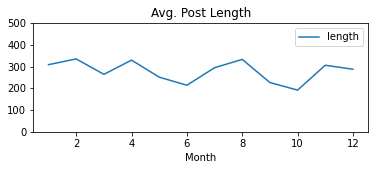

In [124]:
# Plot the average post length
merged_sd_df.groupby('Month').agg({'length': 'mean'}) \
  .plot(title="Avg. Post Length", ylim=(0,500), figsize=(6,2))

In [ ]:
def count_words(df, column='Contents_Normalized', preprocess=None, min_freq=2):

    # process tokens and update counter
    def update(doc):
        tokens = doc if preprocess is None else preprocess(doc)
        counter.update(tokens)

    # create counter and run through all data
    counter = Counter()
    tqdm.pandas() #initialize tqdm for progress bar
    df[column].apply(update)

    # transform counter into data frame
    freq_df = pd.DataFrame.from_dict(counter, orient='index', columns=['freq'])
    freq_df = freq_df.query('freq >= @min_freq')
    freq_df.index.name = 'token'
    
    return freq_df.sort_values('freq', ascending=False)

In [125]:
freq_df = count_words(merged_sd_df)
freq_df.head(5)

,freq
token,
padr,3767
season,3481
year,2697
mm,2363
leagu,1831


In [126]:
#How many tokens are in the df?
len(freq_df)

6529

[Text(0.5, 0, 'Frequency'), Text(0, 0.5, 'Token'), Text(0.5, 1.0, 'Top Words')]

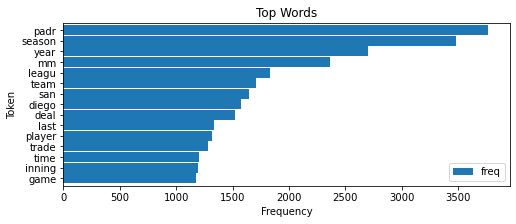

In [127]:
# top words with 10+ characters
count_words(merged_sd_df, column='Content', 
            preprocess=lambda Content: re.findall(r"\w{10,}", Content)).head(5)


ax = freq_df.head(15).plot(kind='barh', width=0.95, figsize=(8,3))
ax.invert_yaxis()
ax.set(xlabel='Frequency', ylabel='Token', title='Top Words')

# Combine to one df for further analysis and modeling

In [129]:
comb_df = pd.concat([merged_df, merged_sd_df], ignore_index= True)
len(comb_df)

2000

In [130]:
comb_df.head()

,Title,Author,Date,Content,Year,success,Year_Successful,impurity,Contents_Normalized,length,Title_length,Month
0,"Sean Doolittle Completes Rehab Assignment, Heads To Triple-A Rochester",Steve Adams,2023-06-15,Veteran lefty Sean Doolittle was transferred from the Nationals’ Double-A affiliate to their Tri...,2023,0,0,0.000000,"[veteran, lefti, sean, doolittl, transfer, nation, doublea, affili, triplea, club, thursday, sig...",60,70,6
1,Nationals Release Erasmo Ramírez,Darragh McDonald,2023-06-09,"The Nationals have released right-hander Erasmo Ramírez, according to his transactions tracker a...",2023,0,0,0.000000,"[nation, releas, righthand, erasmo, ram, rez, accord, transact, tracker, mlbcom, design, assign,...",130,32,6
2,"Best Deadline Rental Returns In Recent History, #8: Nationals Get Everyday Outfielder For Jon Le...",Darragh McDonald,2023-06-08,"With the trade deadline now less than two months away, we at MLBTR are setting our sights backwa...",2023,0,0,0.000441,"[trade, deadlin, less, two, month, away, mlbtr, set, sight, backward, bit, highlight, past, trad...",607,100,6
3,Nationals Claim Joe La Sorsa,Steve Adams,2023-06-08,"The Nationals have claimed left-hander Joe La Sorsa off waivers from the Rays, the team announce...",2023,0,0,0.000000,"[nation, claim, lefthand, joe, la, sorsa, waiver, ray, team, announc, thursday, la, sorsa, desig...",158,28,6
4,Nationals Outright Andres Machado,Anthony Franco,2023-06-07,Nationals reliever Andrés Machado has gone unclaimed on waivers after being designated for assig...,2023,0,0,0.000000,"[nation, reliev, andr, machado, gone, unclaim, waiver, design, assign, week, club, announc, mach...",136,33,6


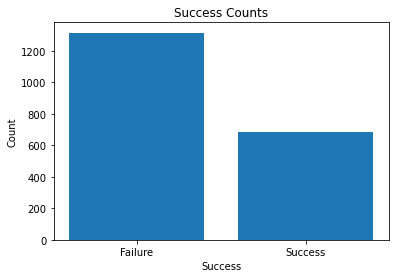

In [131]:
# Count the number of successes and failures
success_counts = comb_df['success'].value_counts()

# Create a bar plot
plt.bar(success_counts.index, success_counts.values)
plt.xticks(success_counts.index, ['Failure', 'Success'])
plt.xlabel('Success')
plt.ylabel('Count')
plt.title('Success Counts')

# Display the plot
plt.show()

# Modeling

## Logistic Regression Modeling

In [132]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [133]:
X_train, X_test, y_train, y_test = train_test_split(comb_df['Content'], comb_df['success'], test_size=0.2, random_state=42)


In [134]:
vectorizer = TfidfVectorizer()
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

In [135]:
model = LogisticRegression()
model.fit(X_train_vec, y_train)

LogisticRegression()

In [137]:
y_pred = model.predict(X_test_vec)

In [138]:
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.7425


## Penalized Logistic Regression

In [146]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import GridSearchCV

In [145]:
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10]}
grid_search = GridSearchCV(LogisticRegression(penalty='l2'), param_grid, cv=5)
grid_search.fit(X_train_vec, y_train)

best_C = grid_search.best_params_['C']


c:\Users\earne\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [141]:
model = LogisticRegression(penalty='l2', C=best_C)
model.fit(X_train_vec, y_train)


c:\Users\earne\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(C=10)

In [142]:
y_pred = model.predict(X_test_vec)


In [147]:
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print(classification_report(y_test, y_pred))


Accuracy: 0.7725
              precision    recall  f1-score   support

           0       0.80      0.89      0.84       274
           1       0.69      0.51      0.58       126

    accuracy                           0.77       400
   macro avg       0.74      0.70      0.71       400
weighted avg       0.76      0.77      0.76       400



In [148]:
coefficients = model.coef_
print(coefficients)

[[ 0.4098832  -0.08912221 -0.10760302 ...  0.07008852 -0.03081552
  -0.111183  ]]


c:\Users\earne\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


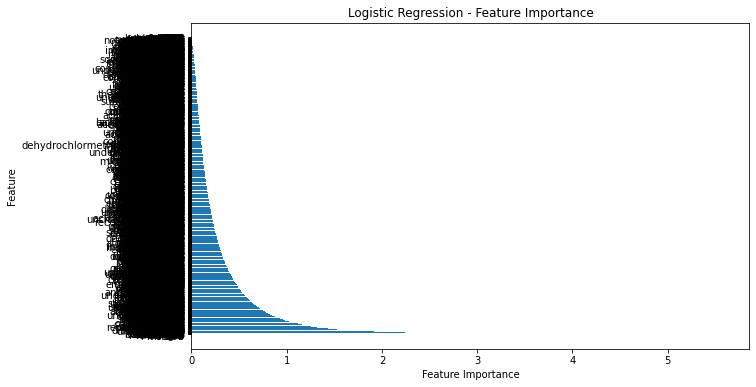

In [154]:

# Retrieve feature names from vectorizer
feature_names = vectorizer.get_feature_names_out()

# Calculate feature importance
feature_importance = np.abs(model.coef_[0])

# Sort feature importance in descending order
sorted_indices = np.argsort(feature_importance)[::-1]
sorted_feature_importance = feature_importance[sorted_indices]
sorted_feature_names = feature_names[sorted_indices]


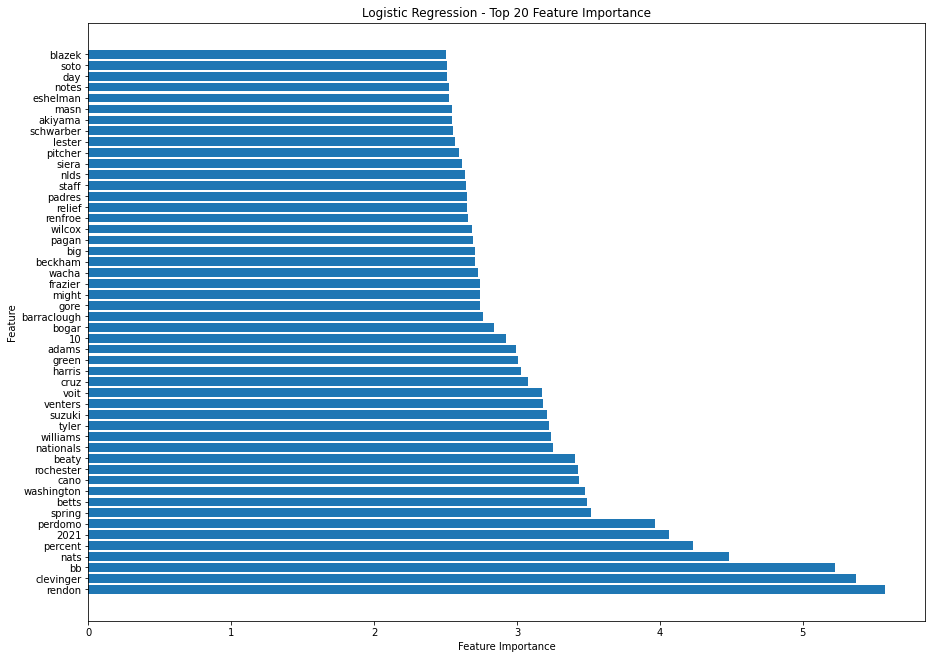

In [157]:
# Select top 20 features
top_feature_importance = sorted_feature_importance[:50]
top_feature_names = sorted_feature_names[:50]

# Plot top 20 feature importance
plt.figure(figsize=(15, 11))
plt.barh(range(len(top_feature_names)), top_feature_importance, align='center')
plt.yticks(range(len(top_feature_names)), top_feature_names)
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Logistic Regression - Top 20 Feature Importance')
plt.show()